In [2]:
import os
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

## EDA

In [28]:
temp_mask = cv2.imread('rs19_val/uint8/rs19_val/rs08171.png') #3 channels but all same. 
labels, count = np.unique(temp_mask[:,:,0], return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)

Labels are:  [ 1  5  7  8  9 10 12 15 17]  and the counts are:  [ 87902  26120   3233 407270 447899 653323 157262 247332  43259]


In [31]:
type(temp_mask)

numpy.ndarray

In [39]:
w = temp_mask.shape[0]
l = temp_mask.shape[1]

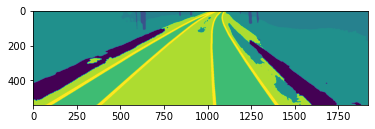

In [49]:

plt.imshow(temp_mask[int(w/2):,:,0])


In [41]:


plt.imshow(temp_mask[:(w/2),:(l/2),0])


TypeError: slice indices must be integers or None or have an __index__ method

In [20]:
len(np.unique(temp_mask[:,:,0]))

9

## Preprosessing

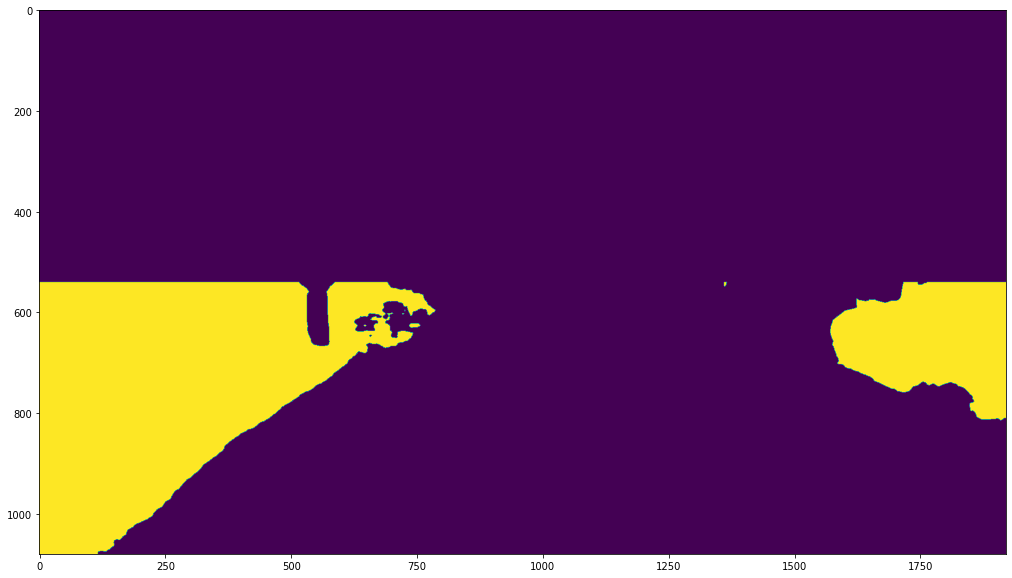

In [56]:
#these codes are used to loop through the directory
path_images = 'rs19_val/jpgs/rs19_val/'
path_mask = 'rs19_val/uint8/rs19_val/'
breaker = 0

image_dataset = []
mask_dataset = []

label_of_interest = 8 #veg
plt.figure(figsize = (20,10))

for filename in os.listdir(path_images):
    breaker +=1
    if filename.endswith('.jpg'):  
        image = cv2.imread(path_images+filename) 
        mask = cv2.imread(path_mask+filename[:7]+'.png')
        mask[:int(w/2),:,0]=0
        mask[:,:,0][mask[:,:,0]!=label_of_interest]=0
        plt.imshow(mask[:,:,0])
        #plt.imshow(image)
        image = np.array(image)
        image_dataset.append(image)
        mask_dataset.append(mask)
    if breaker==2:
         break
      


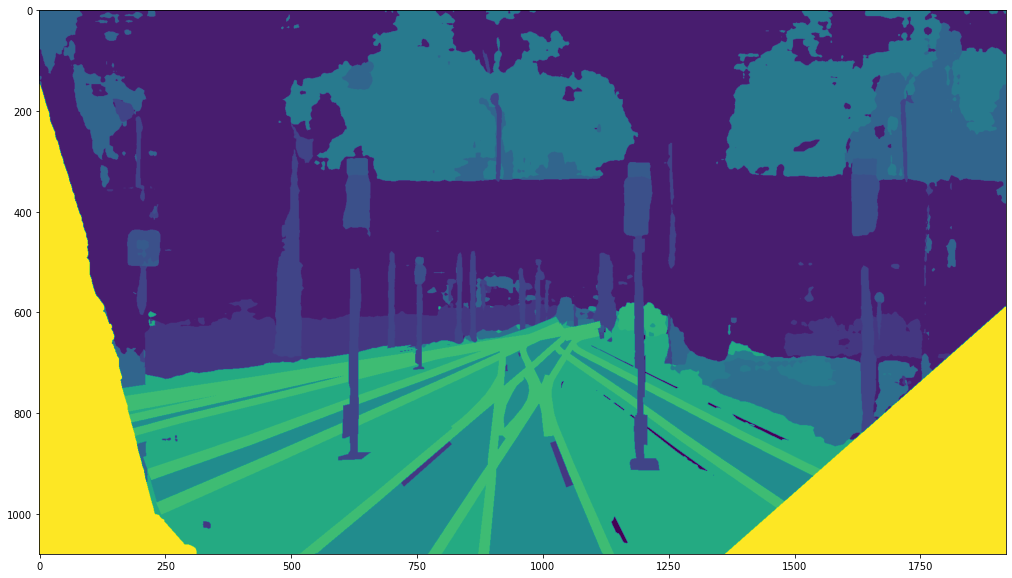

In [27]:

#these codes are used to loop through the directory
path_images = 'rs19_val/jpgs/rs19_val/'
path_mask = 'rs19_val/uint8/rs19_val/'
breaker = 0

image_dataset = []
mask_dataset = []

label_of_interest = 8 #veg
plt.figure(figsize = (20,10))
number_of_unique_labesl = np.unique(mask)

for filename in os.listdir(path_images):
    breaker +=1
    if filename.endswith('.jpg'):  
        image = cv2.imread(path_images+filename) 
        mask = cv2.imread(path_mask+filename[:7]+'.png')
        for l in np.unique(mask[:,:,0]):
            mask[:,:,0][mask[:,:,0]==l]=l*10
        plt.imshow(mask[:,:,0])
        #plt.imshow(image)
        image = np.array(image)
        image_dataset.append(image)
        mask_dataset.append(mask)
    if breaker==1:
         break

In [2]:
#from patchify import patchify
from PIL import Image
import segmentation_models as sm
#from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
#these codes are used to loop through the directory
path_images = 'rs19_val/jpgs/rs19_val/'
path_mask = 'rs19_val/uint8/rs19_val/'
breaker = 0

image_dataset = []
mask_dataset = []

for filename in os.listdir(path_images):
    breaker +=1
    if filename.endswith('.jpg'):  
        image = cv2.imread(path_images+filename) 
        mask = cv2.imread(path_mask+filename[:7]+'.png')
        #plt.imshow(image)
        image = np.array(image)
        image_dataset.append(image)
        mask_dataset.append(mask)
    if breaker==10:
         break
      


In [ ]:
import keras

In [4]:
n_classes = len(np.unique(mask_dataset))
from keras.utils import to_categorical
labels_cat = to_categorical(mask_dataset, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)


ModuleNotFoundError: No module named 'keras'

In [2]:
import segmentation_models as sm

In [1]:
from sklearn.model_selection import train_test_split

In [16]:
image_dataset

[array([[[19, 24, 27],
         [21, 26, 29],
         [19, 26, 29],
         ...,
         [ 0,  3,  4],
         [ 0,  2,  3],
         [ 0,  3,  4]],
 
        [[19, 24, 27],
         [21, 26, 29],
         [19, 26, 29],
         ...,
         [ 1,  5,  6],
         [ 0,  3,  4],
         [ 0,  4,  5]],
 
        [[17, 24, 27],
         [19, 26, 29],
         [19, 26, 29],
         ...,
         [ 1,  5,  6],
         [ 0,  4,  5],
         [ 0,  4,  5]],
 
        ...,
 
        [[ 7,  2,  4],
         [ 7,  2,  4],
         [ 7,  2,  4],
         ...,
         [21, 15, 26],
         [22, 16, 27],
         [24, 18, 29]],
 
        [[ 7,  2,  4],
         [ 7,  2,  4],
         [ 7,  2,  4],
         ...,
         [22, 14, 25],
         [24, 16, 27],
         [26, 18, 29]],
 
        [[ 7,  2,  4],
         [ 7,  2,  4],
         [ 7,  2,  4],
         ...,
         [21, 13, 24],
         [23, 15, 26],
         [26, 18, 29]]], dtype=uint8),
 array([[[ 74,  99,  89],
         [ 70,  

# Appendix

In [26]:
labels = [[1,2,3,1,2,3],[4,1,1,1,1,2]]
labels = np.array(labels)
print(labels.shape)
print(labels)   
labels = np.expand_dims(labels, axis=2)
print(labels.shape)
print(labels) 


(2, 6)
[[1 2 3 1 2 3]
 [4 1 1 1 1 2]]
(2, 6, 1)
[[[1]
  [2]
  [3]
  [1]
  [2]
  [3]]

 [[4]
  [1]
  [1]
  [1]
  [1]
  [2]]]
